## Stroke Prediction Using ML techniques

Steps used in Data Analysis
1. Data Loading
2. Data Cleaning
3. Data analysis
4. EDA
5. Modelling

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from collections import Counter
from tensorflow.keras import layers, models #neural network architecture
from tensorflow.keras.callbacks import EarlyStopping #regularization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras #keras
import tensorflow as tf #tensorflow

In [3]:
#0 - no stroke
#1 - stroke

In [4]:
# Importing dataset
strokePredData = pd.read_csv('healthcare-dataset-stroke-data.csv',header=0,encoding = 'unicode_escape')
strokePredData.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
strokePredData.shape

(5110, 12)

The dataset contains 5110 observations and 12 features

In [6]:
strokePredData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


The dataset has float, int and object data types. 
All the columns are non null.

In [7]:
strokePredData.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


There is a huge gap in 75 percentile and max value of avg_glucose_level , bmi. Which indicates there are outliers

In [8]:
strokePredData.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

bmi column has 201 null values which needs to be handled. bmi column cannot be dropped as it is one of the important feature.

In [9]:
# Let's drop the first id column as its not significant
strokePredData.drop('id', axis=1, inplace = True)
strokePredData = strokePredData.reset_index(drop = True)
strokePredData.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [10]:
#Verifying unique values in Gender col
strokePredData["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [11]:
#Dropping of gender row with 'other as value'
strokePredData.drop(strokePredData.index[strokePredData['gender'] == 'Other'], inplace=True)
strokePredData = strokePredData.reset_index(drop = True)
strokePredData["gender"].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [12]:
strokePredData["hypertension"].value_counts()

0    4611
1     498
Name: hypertension, dtype: int64

In [13]:
strokePredData["smoking_status"].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [14]:
strokePredData["ever_married"].value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

 BMI has null values. it needs to be filled with maximum occurance value.

In [15]:

#Filling null values of bmi by mean value
strokePredData['bmi'] = strokePredData['bmi'].fillna(strokePredData['bmi'].mean())
# Check to see there are no more missing values
strokePredData.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [16]:
strokePredData.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.894560,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.698235,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


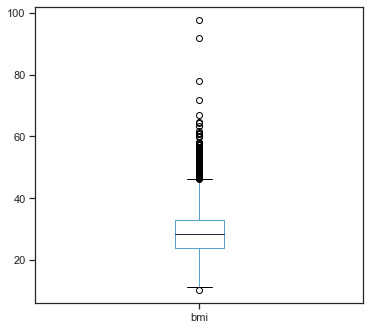

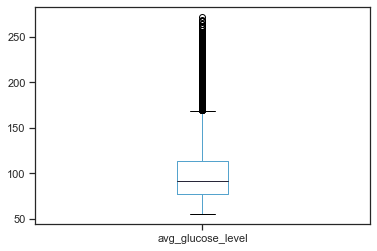

In [17]:
#Plotting the bmi and avg glocose level numbers to check outliers.
plt.figure(figsize=(20, 12))
sns.set_theme(style="ticks", palette="icefire")
plt.subplot(2,3,1)
strokePredData['bmi'].plot(kind='box');
plt.show()
strokePredData['avg_glucose_level'].plot(kind='box');
plt.show()

BMI has very high range and these are considered as outliers

In [18]:
display(strokePredData[strokePredData['bmi'] > 80])

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2128,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4208,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0


There are only 2 rows with high BMI. These will not be removed and is used as learning.

In [21]:
strokePredData.shape

(5109, 11)

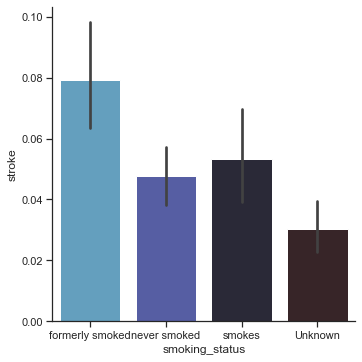

In [22]:
sns.catplot(data=strokePredData, kind="bar", x="smoking_status", y="stroke")

This shows that the person who smokes and never smokes have same level of stroke prediction. But this has unkown values which needs to be taken care of.

<AxesSubplot:xlabel='stroke', ylabel='age'>

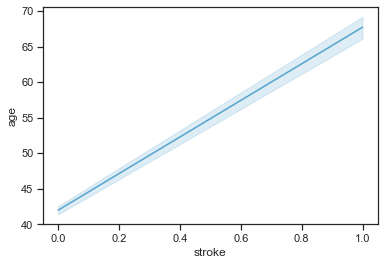

In [23]:
sns.lineplot(data=strokePredData, x="stroke", y="age")

This shows that the risk of stroke attack increases with increase in age.

<AxesSubplot:xlabel='bmi', ylabel='heart_disease'>

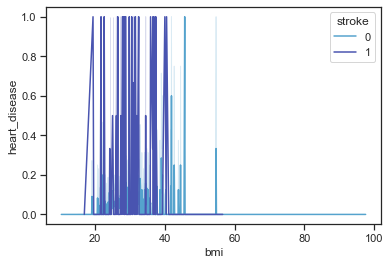

In [24]:
#line plot for stroke, bmi vs heart diesase
sns.lineplot(data=strokePredData, x="bmi", y="heart_disease", hue="stroke")

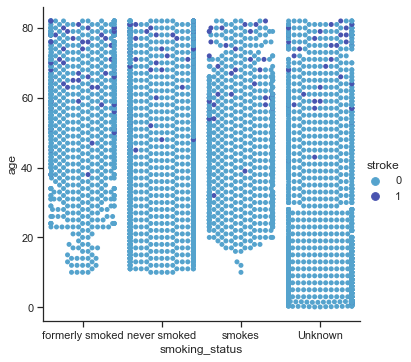

In [25]:
#smoking status vs age
#plot tells us there are a number of people below 30 who smoke, but they do not have stroke
sns.catplot(data=strokePredData, kind="swarm", x="smoking_status", y="age", hue = "stroke")

#### 

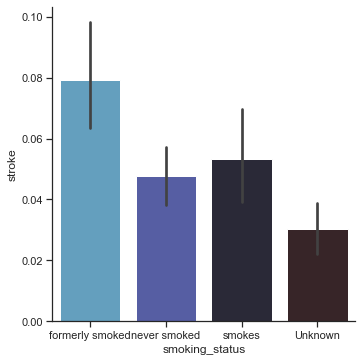

In [27]:
# Catplot to show stroke and smoking status
sns.catplot(data=strokePredData, kind="bar", x="smoking_status", y="stroke")

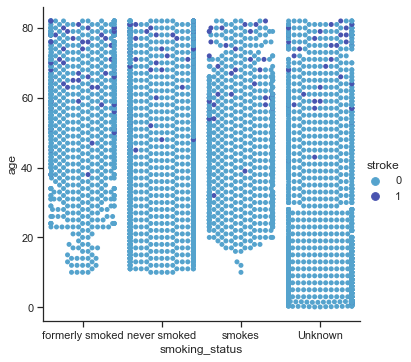

In [28]:
#smoking status vs age
#plot tells us there are a number of people below 30 who smoke, but they do not have stroke
#smoking_status
sns.catplot(data=strokePredData, kind="swarm", x="smoking_status", y="age", hue = "stroke")

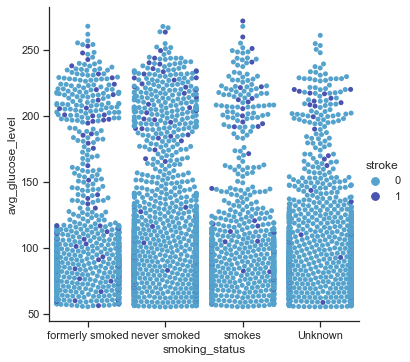

In [29]:
#avg_glucose_level, smoking status, stroke 
sns.catplot(data=strokePredData, kind="swarm", x="smoking_status", y="avg_glucose_level", hue = "stroke")

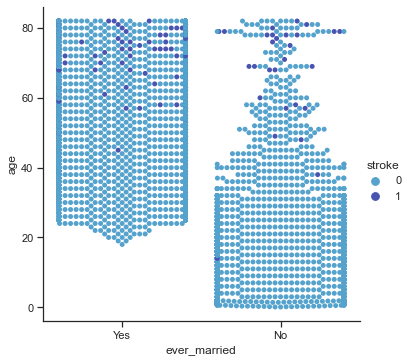

In [30]:
#ever married, age and stroke
#plot shows that a higher number of married people have stroke compared to the single folks
sns.catplot(data=strokePredData, kind="swarm", x="ever_married", y="age", hue="stroke") 

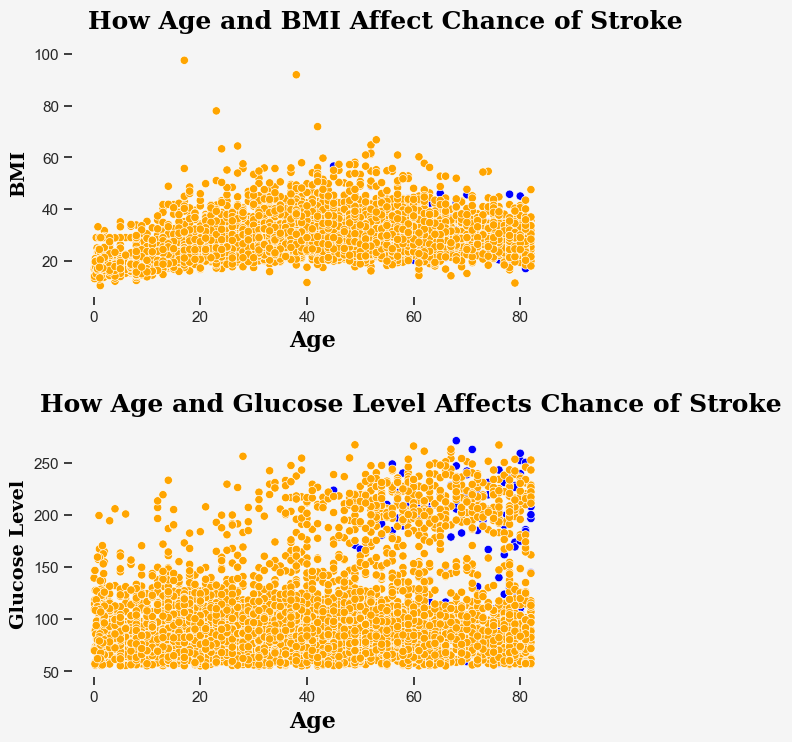

In [31]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (18,10), dpi = 100)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['orange','blue']))

ax1 = fig.add_subplot(gs[2:6, 0:6])
ax2 = fig.add_subplot(gs[8:, 0:6])


# axes list
axes = [ ax1,ax2]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.set_facecolor('#f5f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.scatterplot(x='age', y='bmi', hue='stroke', data=strokePredData, ax=ax1)
ax1.get_legend().remove()
ax1.set_xlabel('Age', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax1.set_ylabel('BMI', {'font':'Serif', 'fontsize':14,'fontweight':'bold', 'color':'black'})
ax1.text(-1, 110, 'How Age and BMI Affect Chance of Stroke', 
         {'font':'Serif', 'size':'18','color': 'black','weight':'bold'})

#-------Ax 2------------------------------------------------
sns.scatterplot(x='age', y='avg_glucose_level', hue='stroke', data=strokePredData, ax=ax2)
ax2.get_legend().remove()
ax2.set_xlabel('Age', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax2.set_ylabel('Glucose Level', {'font':'Serif', 'fontsize':14,'fontweight':'bold', 'color':'black'})
ax2.text(-10, 300, 'How Age and Glucose Level Affects Chance of Stroke', 
         {'font':'Serif', 'size':'18','color': 'black','weight':'bold'})

plt.show()

Inference: This plot shows the distribution of raw data of and the bivariate analysis between age and glucose, age and BMI. 
and the age and glucose level increases the chances of stroke increases. same thing with age and bmi. But bmi and age combination has little 
#occurance of stroke. hence we can see that blood-glucose-level has high role in stroke.

Text(0, 0.5, 'Individuals with stroke: Smoking status')

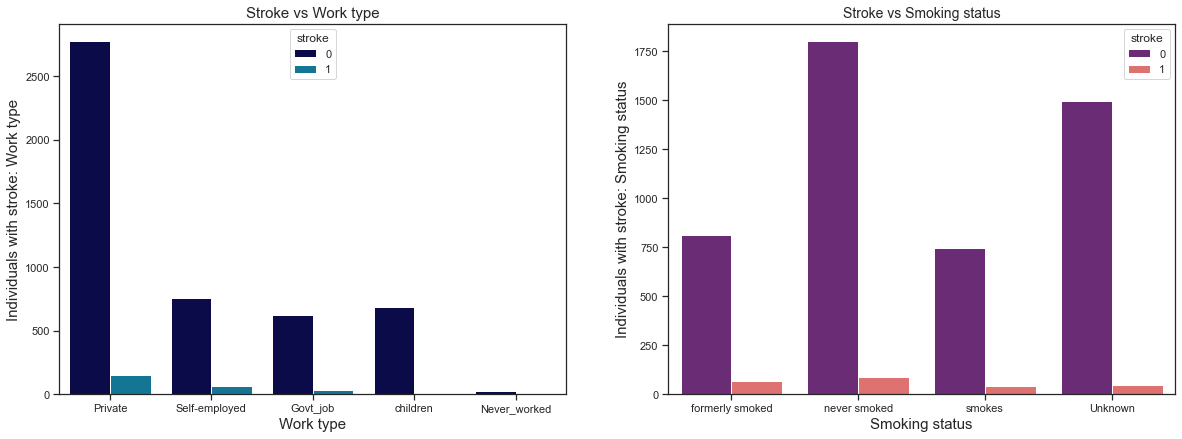

In [33]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
sns.countplot(x = strokePredData.work_type, hue = strokePredData.stroke, palette="ocean")
plt.title('Stroke vs Work type', fontsize=15)
plt.xlabel('Work type', fontsize=15)
plt.ylabel('Individuals with stroke: Work type', fontsize=15)

plt.subplot(2,2,2)
sns.countplot(x = strokePredData.smoking_status, hue = strokePredData.stroke, palette="magma")
plt.title('Stroke vs Smoking status', fontsize=14)
plt.xlabel('Smoking status', fontsize=15)
plt.ylabel('Individuals with stroke: Smoking status', fontsize=15)

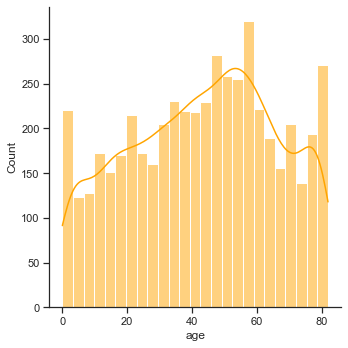

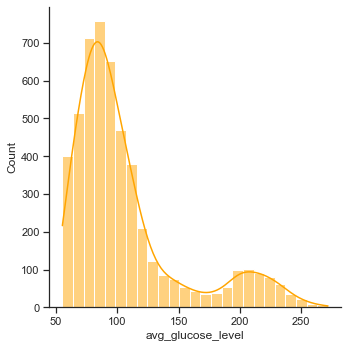

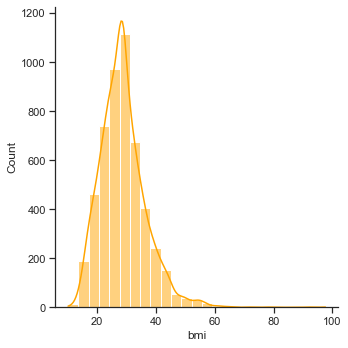

In [35]:
cont_cols=['age','avg_glucose_level','bmi']
for feature in cont_cols:
    sns.displot(strokePredData[feature],kde=True,bins=25)

Above 3 plots show the spread of data and skewness.

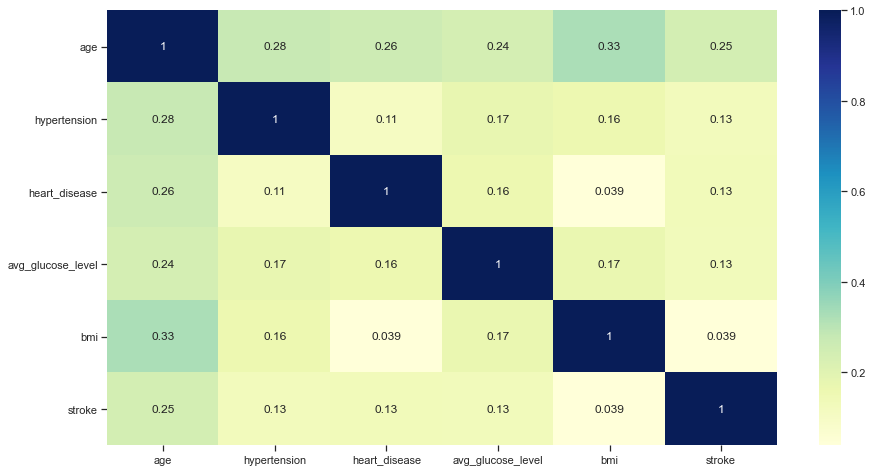

In [36]:
plt.figure(figsize=(15, 8))
sns.heatmap(strokePredData.corr(), cmap="YlGnBu", annot=True)
plt.show()

Heat map of all variables to understand the corelation between variables.

In [37]:
new_work_type ={'Private' : 'Work',
               'Self-employed' : 'Work',
                 'children': 'No Work',
                 'Govt_job' : 'Work',
                 'Never_worked' : 'No Work'
                }
# Replace old values with new
strokePredData['work_type'].replace(new_work_type, inplace = True)
strokePredData['work_type'].value_counts()

Work       4400
No Work     709
Name: work_type, dtype: int64

### Checking Imbalance dataset

In [38]:
print(strokePredData['stroke'].value_counts())

0    4860
1     249
Name: stroke, dtype: int64


In [39]:
100*(4858/float(strokePredData.shape[0]))

95.08710119397142

In [40]:
100*(249/float(strokePredData.shape[0]))

4.873752201996477

Percent of stroke risk:  4.873752201996477 %
Percent of non stroke risk:  95.12624779800353 %


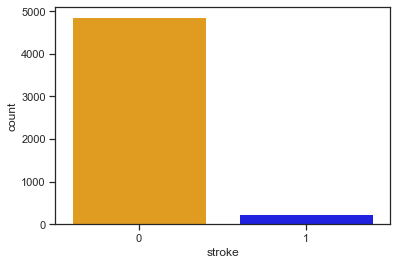

In [41]:
sns.countplot(strokePredData['stroke'])
print('Percent of stroke risk: ',len(strokePredData[strokePredData['stroke']==1])/len(strokePredData['stroke'])*100,"%")
print('Percent of non stroke risk: ',len(strokePredData[strokePredData['stroke']==0])/len(strokePredData['stroke'])*100,"%")

In [42]:
# Grouping all continous values

category_cols=[]
for i in strokePredData.columns:
    if i!='id' and i!='stroke' and i not in cont_cols:
        category_cols.append(i)
category_cols

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status']

In [43]:
print("Before encoding")
strokePredData.head()

Before encoding


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Work,Urban,228.69,36.60000,formerly smoked,1
1,Female,61.0,0,0,Yes,Work,Rural,202.21,28.89456,never smoked,1
2,Male,80.0,0,1,Yes,Work,Rural,105.92,32.50000,never smoked,1
3,Female,49.0,0,0,Yes,Work,Urban,171.23,34.40000,smokes,1
4,Female,79.0,1,0,Yes,Work,Rural,174.12,24.00000,never smoked,1


### Encoding the categorical variables

In [44]:
# Initialize One Hot Encoder
one_hot_encoder = OneHotEncoder()
# Fit and Transform the columns
df_temp = one_hot_encoder.fit_transform(strokePredData[['gender','hypertension','heart_disease', 'ever_married', 'work_type', 'Residence_type','smoking_status']]).toarray()

# Get newly encoded columns and concat them to the Dataframe
encodings = pd.DataFrame(columns = one_hot_encoder.get_feature_names_out(),data = df_temp)
encodings = encodings.astype(int)
strokePredData = pd.concat([strokePredData,encodings] , axis=1)

# Drop original columns from the dataset after encoding is done
##strokePredData.drop(['gender','hypertension','heart_disease', 'ever_married', 'work_type', 'Residence_type','smoking_status'],axis = 1, inplace=True)
strokePredData.drop(category_cols,axis=1,inplace=True)
strokePredData.drop(['gender_Female','hypertension_0','heart_disease_0','ever_married_No','work_type_No Work','Residence_type_Rural','smoking_status_Unknown'],axis=1,inplace=True)
strokePredData.head()

,age,avg_glucose_level,bmi,stroke,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Work,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.60000,1,1,0,1,1,1,1,1,0,0
1,61.0,202.21,28.89456,1,0,0,0,1,1,0,0,1,0
2,80.0,105.92,32.50000,1,1,0,1,1,1,0,0,1,0
3,49.0,171.23,34.40000,1,0,0,0,1,1,1,0,0,1
4,79.0,174.12,24.00000,1,0,1,0,1,1,0,0,1,0


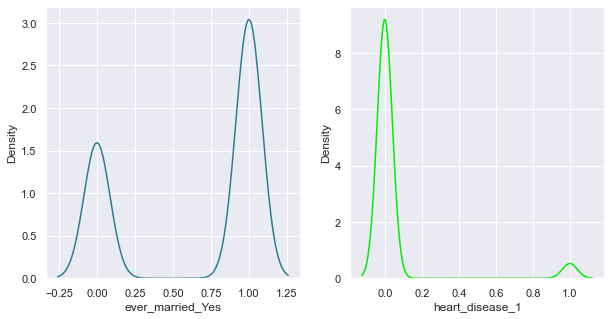

In [45]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
sns.kdeplot(strokePredData.ever_married_Yes, color=sns.color_palette('viridis')[2])
plt.subplot(1, 2, 2)
sns.kdeplot(strokePredData.heart_disease_1, color=sns.color_palette('nipy_spectral_r')[2])
plt.show()

Inference - The plot shows the density of the married and heart disease

#### Seperating target variable(Y) from dependent variables(X).

In [47]:
# Separating 'Stroke' from the dataset. 'Stroke' is assigned to y.
X = strokePredData.drop(['stroke'],axis=1)
y = strokePredData['stroke']

In [48]:
X.head()

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Work,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.60000,1,0,1,1,1,1,1,0,0
1,61.0,202.21,28.89456,0,0,0,1,1,0,0,1,0
2,80.0,105.92,32.50000,1,0,1,1,1,0,0,1,0
3,49.0,171.23,34.40000,0,0,0,1,1,1,0,0,1
4,79.0,174.12,24.00000,0,1,0,1,1,0,0,1,0


In [49]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: stroke, dtype: int64

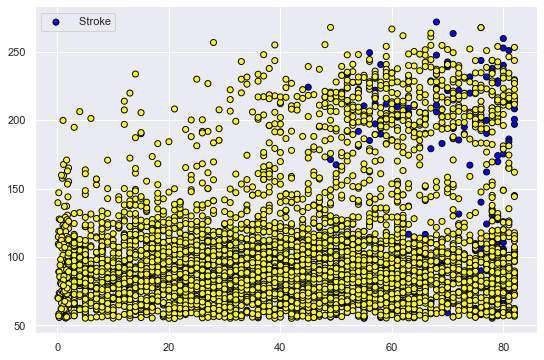

In [101]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,6)
colors = ['yellow' if x == 0 else 'blue' if x == 1 else 'blue' for x in y]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=colors, **kwarg_params)
#plt.scatter(X.iloc[:, 0], y.iloc[:, 0], c=colors, **kwarg_params)
plt.legend(labels=[" Stroke","No Stroke"])
sns.despine()

Inference: shows the spread of data and it is highly imbalanced with only few postive cases.

## MODELLING

#### Balancing the dataset

In [52]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN


#from imblearn.over_sampling import RandomOverSampler
#oversample = RandomOverSampler(sampling_strategy='minority')
#X_train_res, y_train_res = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=20,stratify=y)
# Using SMOTE over sampling method to handle imbalanced dataset
print("Total y column", strokePredData['stroke'].value_counts())
print("########################################")
print("checking y_train,y_test counts after  stratify, before SMOTE")
print("y train after stratify", y_train.value_counts())
print("y test after stratify", y_test.value_counts())
print("#############################################")
print("Before OverSampling, counts of label '1':",sum(y==1))
print("Before OverSampling, counts of label '0':",sum(y==0))
print("############################################")
# Training the data on SMOTE resampled train data.
##sm = SMOTE(sampling_strategy='minority',random_state=20)
##X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('Before SMOTE-ENN ytrain', counter)
smtom = SMOTEENN(random_state=20) 
X_train_res, y_train_res = smtom.fit_resample(X_train, y_train)
counter1 = Counter(y_train_res)
print('after SMOTE-ENN ytrain', counter1)
print("checking 0,1 counts after stratify and SMOTE")
print("y train after stratify and SMOTE ", y_train_res.value_counts())
print("y test after stratify and SMOTE", y_test.value_counts())
print("########################################")
print("After OverSampling, counts of label '1':",sum(y_train_res==1))
print("After OverSampling, counts of label '0':",sum(y_train_res==0))

Total y column 0    4860
1     249
Name: stroke, dtype: int64
########################################
checking y_train,y_test counts after  stratify, before SMOTE
y train after stratify 0    3402
1     174
Name: stroke, dtype: int64
y test after stratify 0    1458
1      75
Name: stroke, dtype: int64
#############################################
Before OverSampling, counts of label '1': 249
Before OverSampling, counts of label '0': 4860
############################################
Before SMOTE-ENN ytrain Counter({0: 3402, 1: 174})
after SMOTE-ENN ytrain Counter({1: 3146, 0: 2577})
checking 0,1 counts after stratify and SMOTE
y train after stratify and SMOTE  1    3146
0    2577
Name: stroke, dtype: int64
y test after stratify and SMOTE 0    1458
1      75
Name: stroke, dtype: int64
########################################
After OverSampling, counts of label '1': 3146
After OverSampling, counts of label '0': 2577


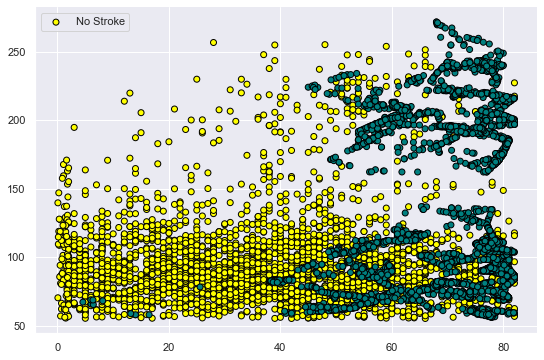

In [53]:
plt.rcParams["figure.figsize"] = (9,6)
colors = ['yellow' if x == 0 else 'teal' if x == 1 else 'blue' for x in y_train_res]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_train_res.iloc[:, 0], X_train_res.iloc[:, 1], c=colors, **kwarg_params)
plt.legend(labels=["No Stroke","Stroke"])
sns.despine()

#### Standard Scaling Technique 

In [54]:
#Standard Scalaing Technique to scale up the numerical Columns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.sqrt)
X_train_res[cont_cols] =transformer.fit_transform(X_train_res[cont_cols])
X_train_res.head()


,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Work,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,3.741657,10.593394,5.186521,1,0,0,0,0,0,0,0,0
1,7.141428,9.641058,4.888763,0,0,0,1,1,0,0,1,0
2,6.082763,7.749194,4.909175,0,0,0,1,1,1,0,0,0
3,6.000000,7.604604,4.647580,0,0,0,0,1,1,0,0,1
4,3.162278,8.408329,5.039841,1,0,0,0,0,1,0,0,0


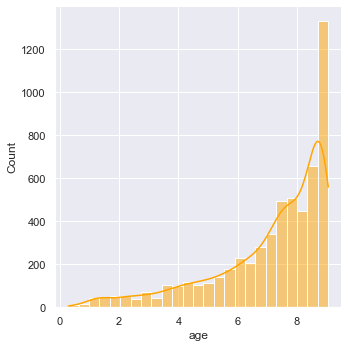

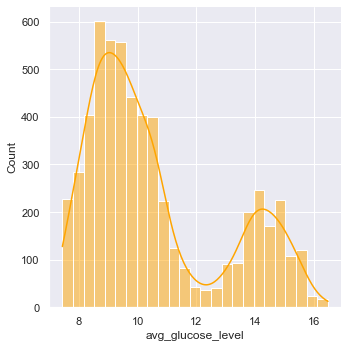

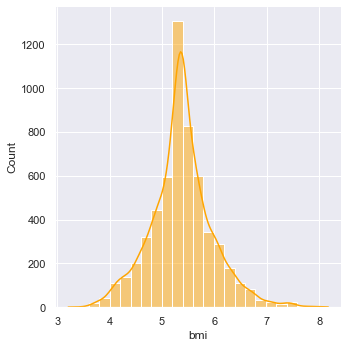

In [55]:
for feature in cont_cols:
    sns.displot(X_train_res[feature],kde=True,bins=25)

Inference- spread of data after applying scaling techniqu. data is almost following the gaussian curve.

In [56]:
# bmi plot after sqrt transformation. We can see that skewness is reduced.

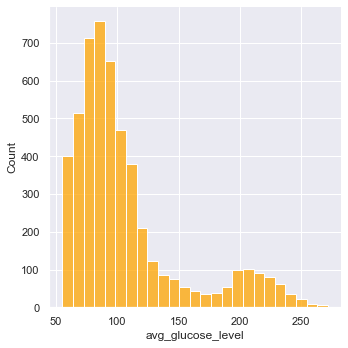

In [57]:
sns.displot(strokePredData['avg_glucose_level'],bins=25)

#### LOGISTIC REGRESSION

In [58]:
#### LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn import metrics

#param_grid={'C':[0.001,0.01,0.1,1,10,100], 'max_iter':[50,75,100,200,300,400,500,700]}
#lr = RandomizedSearchCV(LogisticRegression(solver='newton-cg'), param_grid,cv=5)
lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr.fit(X_train_res, y_train_res)

# Predicting on the test data
pred_test = lr.predict(X_test)

#Ploting the confusion matrix
print(classification_report(y_test, pred_test))
confusion = metrics.confusion_matrix(y_test, pred_test )
print(confusion)

tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))
#print(y_train)



              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1458
           1       0.05      1.00      0.09        75

    accuracy                           0.05      1533
   macro avg       0.02      0.50      0.05      1533
weighted avg       0.00      0.05      0.00      1533

[[   0 1458]
 [   0   75]]
tp - stroke predicted as stroke 75
tn - non stroke predicted as non stroke 0
fn - Stroke predicted as non stroke 0
fp - non stroke predicted as stroke 1458
Sensitivity 1.0
specificity 0.0


In [60]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier()
randomForest.fit(X_train_res, y_train_res)
randomForestPredict = randomForest.predict(X_test)
print(classification_report(y_test, randomForestPredict))
print(confusion_matrix(y_test, randomForestPredict))

tn, fp, fn, tp = confusion_matrix(y_test, randomForestPredict).ravel()
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))

              precision    recall  f1-score   support

           0       0.95      0.27      0.42      1458
           1       0.05      0.71      0.09        75

    accuracy                           0.29      1533
   macro avg       0.50      0.49      0.26      1533
weighted avg       0.90      0.29      0.41      1533

[[ 398 1060]
 [  22   53]]
tp - stroke predicted as stroke 53
tn - non stroke predicted as non stroke 398
fn - Stroke predicted as non stroke 22
fp - non stroke predicted as stroke 1060
Sensitivity 0.7066666666666667
specificity 0.2729766803840878


In [62]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dTPredict = dt.predict(X_test)
print(classification_report(y_test, dTPredict))
print(confusion_matrix(y_test, dTPredict))

tn, fp, fn, tp = confusion_matrix(y_test, dTPredict).ravel()
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))
#[[1395   68]
# [  54   16]]

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1458
           1       0.14      0.17      0.16        75

    accuracy                           0.91      1533
   macro avg       0.55      0.56      0.55      1533
weighted avg       0.92      0.91      0.91      1533

[[1380   78]
 [  62   13]]
tp - stroke predicted as stroke 13
tn - non stroke predicted as non stroke 1380
fn - Stroke predicted as non stroke 62
fp - non stroke predicted as stroke 78
Sensitivity 0.17333333333333334
specificity 0.9465020576131687


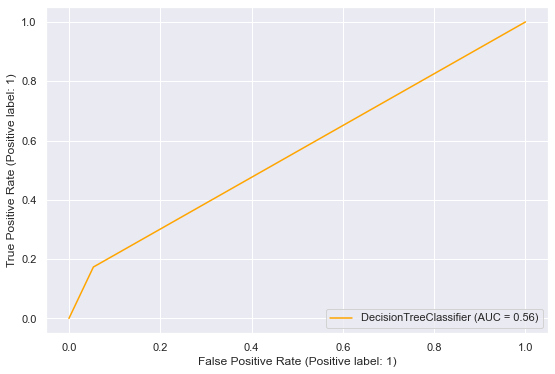

In [63]:
metrics.plot_roc_curve(dt, X_test, y_test)

In [64]:
# ADA BOOST
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(X_train_res, y_train_res)
adaPredict = ada.predict(X_test)
print(classification_report(y_test, adaPredict))
print(confusion_matrix(y_test, adaPredict))

tn, fp, fn, tp = confusion_matrix(y_test, adaPredict).ravel()
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))
#[[1397   66]
 #[  62    8]]

              precision    recall  f1-score   support

           0       0.94      0.30      0.45      1458
           1       0.04      0.64      0.08        75

    accuracy                           0.31      1533
   macro avg       0.49      0.47      0.27      1533
weighted avg       0.90      0.31      0.43      1533

[[ 433 1025]
 [  27   48]]
tp - stroke predicted as stroke 48
tn - non stroke predicted as non stroke 433
fn - Stroke predicted as non stroke 27
fp - non stroke predicted as stroke 1025
Sensitivity 0.64
specificity 0.29698216735253774


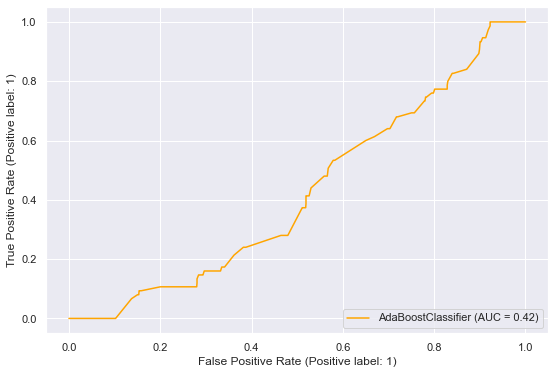

In [65]:
metrics.plot_roc_curve(ada, X_test, y_test)

In [66]:
#XGBOOST Classifier

from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=2,objective='binary:logistic',random_state=95,eval_metric='mlogloss')
##xgb=XGBClassifier(objective='binary:logistic',n_estimators=100000,max_depth=5,learning_rate=0.06,n_jobs=-1)

xgb.fit(X_train_res.values, y_train_res)
xgbPredict= xgb.predict(X_test.values)
print(classification_report(y_test, xgbPredict))
print(confusion_matrix(y_test, xgbPredict))

tn, fp, fn, tp = confusion_matrix(y_test, xgbPredict).ravel()
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))

              precision    recall  f1-score   support

           0       0.93      0.13      0.22      1458
           1       0.05      0.83      0.09        75

    accuracy                           0.16      1533
   macro avg       0.49      0.48      0.16      1533
weighted avg       0.89      0.16      0.22      1533

[[ 186 1272]
 [  13   62]]
tp - stroke predicted as stroke 62
tn - non stroke predicted as non stroke 186
fn - Stroke predicted as non stroke 13
fp - non stroke predicted as stroke 1272
Sensitivity 0.8266666666666667
specificity 0.12757201646090535


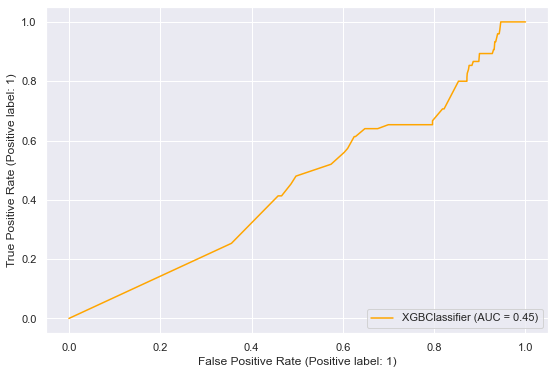

In [67]:
metrics.plot_roc_curve(xgb, X_test, y_test)

In [68]:
## XGBOOST hyper parameter tuning
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05,0.10,0.15,0.20,0.25,0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}


In [69]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=10,verbose=3)

In [70]:
random_search.fit(X_train_res, y_train_res)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [71]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [72]:
random_search.best_params_

{'min_child_weight': 7,
 'max_depth': 12,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [73]:
classifier=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
               monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1)

In [74]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(classifier,X_train_res, y_train_res,cv=10)

In [75]:
score

array([0.90575916, 0.98603839, 0.98080279, 0.97202797, 0.98426573,
       0.97552448, 0.98251748, 0.97902098, 0.97902098, 0.98426573])

In [76]:
xgbPred= random_search.predict(X_test.values)
print(classification_report(y_test,xgbPred))
print(confusion_matrix(y_test, xgbPred))

tn, fp, fn, tp = confusion_matrix(y_test, xgbPred).ravel()
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))

              precision    recall  f1-score   support

           0       0.96      0.13      0.23      1458
           1       0.05      0.89      0.09        75

    accuracy                           0.17      1533
   macro avg       0.50      0.51      0.16      1533
weighted avg       0.91      0.17      0.22      1533

[[ 187 1271]
 [   8   67]]
tp - stroke predicted as stroke 67
tn - non stroke predicted as non stroke 187
fn - Stroke predicted as non stroke 8
fp - non stroke predicted as stroke 1271
Sensitivity 0.8933333333333333
specificity 0.12825788751714678


In [77]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res,y_train_res)
knnpredict =knn.predict(X_test)
print(classification_report(y_test,knnpredict))
print(confusion_matrix(y_test, knnpredict))

tn, fp, fn, tp = confusion_matrix(y_test, knnpredict).ravel()
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1458
           1       0.05      1.00      0.09        75

    accuracy                           0.05      1533
   macro avg       0.02      0.50      0.05      1533
weighted avg       0.00      0.05      0.00      1533

[[   0 1458]
 [   0   75]]
tp - stroke predicted as stroke 75
tn - non stroke predicted as non stroke 0
fn - Stroke predicted as non stroke 0
fp - non stroke predicted as stroke 1458
Sensitivity 1.0
specificity 0.0


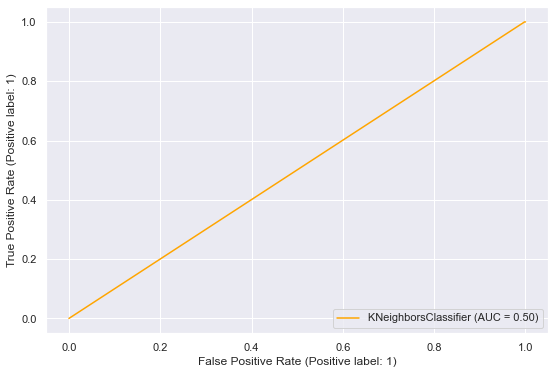

In [78]:
metrics.plot_roc_curve(knn, X_test, y_test)

In [79]:
#SVC
##param_grid={'C':[0.001,0.01,0.1,1,10,100], 'gamma':[0.001,0.01,0.1,1,10,100]}
##svc=RandomizedSearchCV(SVC(),param_grid,cv=5)
svc=SVC()
svc.fit(X_train_res,y_train_res)
svcPredict= svc.predict(X_test)
print(classification_report(y_test,svcPredict))
print(confusion_matrix(y_test, svcPredict))

tn, fp, fn, tp = confusion_matrix(y_test, svcPredict).ravel()
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533

[[1458    0]
 [  75    0]]
tp - stroke predicted as stroke 0
tn - non stroke predicted as non stroke 1458
fn - Stroke predicted as non stroke 75
fp - non stroke predicted as stroke 0
Sensitivity 0.0
specificity 1.0


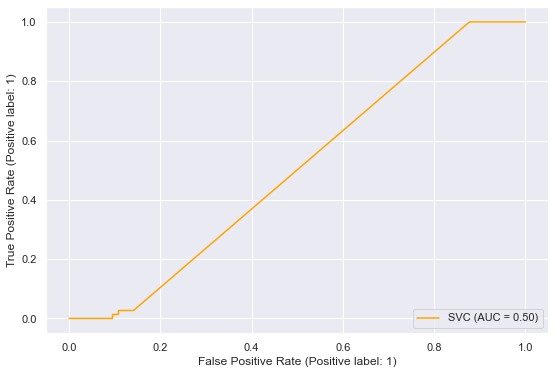

In [80]:
metrics.plot_roc_curve(svc, X_test, y_test)

In [81]:
#BAYESIAN technique for automated hyper parameter tuning
randomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [82]:

def stratified_kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    strat_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in strat_kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)

    return np.array(accuracy_list).mean()

In [83]:
def bo_params_rf(max_samples,n_estimators,max_features):
    
    params = {
        'max_samples': max_samples,
        'max_features':max_features,
        'n_estimators':int(n_estimators)
    }
    clf = RandomForestClassifier(max_samples=params['max_samples'],max_features=params['max_features'],n_estimators=params['n_estimators'])
    score = stratified_kfold_score(clf,X_train_res, y_train_res,5)
    return score

In [84]:
from bayes_opt import BayesianOptimization
rf_bo = BayesianOptimization(bo_params_rf, {
                                                    'max_samples':(0.5,1),
                                                    'max_features':(0.5,1),
                                                    'n_estimators':(100,200)
                                             })

In [85]:
results = rf_bo.maximize(n_iter=100, init_points=20,acq='ei')

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.9637   |  0.8804   |  0.7138   |  161.3    |
|  2        |  0.9628   |  0.7807   |  0.6174   |  139.3    |
|  3        |  0.9661   |  0.8396   |  0.7519   |  196.3    |
|  4        |  0.9642   |  0.863    |  0.8769   |  110.3    |
|  5        |  0.9672   |  0.6162   |  0.8268   |  145.3    |
|  6        |  0.9649   |  0.8208   |  0.9335   |  181.6    |
|  7        |  0.9642   |  0.7072   |  0.6769   |  189.4    |
|  8        |  0.9642   |  0.9735   |  0.8712   |  195.7    |
|  9        |  0.9659   |  0.7186   |  0.6657   |  145.2    |
|  10       |  0.9645   |  0.5353   |  0.5979   |  170.0    |
|  11       |  0.9628   |  0.6767   |  0.5426   |  184.5    |
|  12       |  0.9665   |  0.7387   |  0.8412   |  196.9    |
|  13       |  0.9631   |  0.6987   |  0.5738   |  162.6    |
|  14       |  0.9614   |  0.5297   |  0.5042   |  175.4    |
|  15   

|  80       |  0.9631   |  0.9492   |  0.9628   |  100.8    |
|  81       |  0.9666   |  0.5857   |  0.7452   |  188.8    |
|  82       |  0.9651   |  0.6569   |  0.6305   |  133.0    |
|  83       |  0.9645   |  0.5011   |  0.5946   |  120.2    |
|  84       |  0.9656   |  0.8208   |  0.9243   |  164.2    |
|  85       |  0.9612   |  0.9261   |  0.5638   |  113.3    |
|  86       |  0.9678   |  0.555    |  0.9516   |  138.6    |
|  87       |  0.9659   |  0.5767   |  0.6378   |  165.9    |
|  88       |  0.9626   |  0.8055   |  0.58     |  191.5    |
|  89       |  0.9677   |  0.5705   |  0.8514   |  118.2    |
|  90       |  0.9635   |  0.8879   |  0.6382   |  115.6    |
|  91       |  0.9672   |  0.525    |  0.9542   |  138.7    |
|  92       |  0.9659   |  0.6673   |  0.9115   |  110.2    |
|  93       |  0.9647   |  0.9235   |  0.6799   |  154.7    |
|  94       |  0.9675   |  0.6304   |  0.8729   |  145.2    |
|  95       |  0.9647   |  0.8961   |  0.7127   |  111.0    |
|  96   

In [86]:
params = rf_bo.max['params']
params['n_estimators']= int(params['n_estimators'])
print(params)

{'max_features': 0.6658794729291608, 'max_samples': 0.899754698733761, 'n_estimators': 145}


In [87]:
rf_v1 = RandomForestClassifier(max_samples=params['max_samples'],max_features=params['max_features'],n_estimators=params['n_estimators'])

In [88]:
rf_v1.fit(X_train_res,y_train_res)

RandomForestClassifier(max_features=0.6658794729291608,
                       max_samples=0.899754698733761, n_estimators=145)

In [89]:
preds = rf_v1.predict(X_test)

In [90]:
print(classification_report(preds,y_test))
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1426
           1       0.01      0.01      0.01       107

    accuracy                           0.88      1533
   macro avg       0.47      0.48      0.47      1533
weighted avg       0.86      0.88      0.87      1533

tp - stroke predicted as stroke 0
tn - non stroke predicted as non stroke 1458
fn - Stroke predicted as non stroke 75
fp - non stroke predicted as stroke 0
Sensitivity 0.0
specificity 1.0


In [92]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
scores = []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    rf_v1.fit(X.iloc[train], y.iloc[train])
    preds = rf_v1.predict(X.iloc[test])    
    accuracy = accuracy_score(preds,y.iloc[test])
    scores.append(accuracy)

df_val= pd.DataFrame(scores, columns=['Accuracy Test'])
print("KFold validation mean accuracy on test set : {}".format(df_val['Accuracy Test'].mean()))

KFold validation mean accuracy on test set : 0.9498925691592028


In [93]:
inputs = keras.Input(shape=(12,))
a = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.6)(a)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.concatenate([a, x])
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(1, activation='sigmoid')(x)

nn = keras.Model(inputs, output, name="stroke_predictor")
nn.summary()

Model: "stroke_predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           832         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          8320        ['dropout[0][0]']                
                                                                                   

In [94]:
nn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy', metrics=['accuracy'])
early_stopper = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

#Trains the neural network
history = nn.fit(X_train_res, y_train_res, epochs=1000, callbacks=[early_stopper], validation_data=(X_train_res, y_train_res), verbose=0)

In [95]:
from sklearn.metrics import accuracy_score, recall_score ,precision_score, f1_score
test_preds = nn.predict(X_test)
threshold = 0.25
test_preds = [1. if i > threshold else 0. for i in test_preds]
test_acc = accuracy_score(y_test, test_preds)
test_rec = recall_score(y_test, test_preds)
test_pre = precision_score(y_test, test_preds)
target_names = ['No Stroke', 'stroke']

print('Test Set Metrics')
print('Model Accuracy:', test_acc)
print('Model Recall:', test_rec)
print('Model Precision:', test_pre)

48/48 [==============================] - 0s 1ms/step
Test Set Metrics
Model Accuracy: 0.4390084801043705
Model Recall: 0.7066666666666667
Model Precision: 0.05948372615039282


In [96]:
print(classification_report(y_test,test_preds,target_names=target_names))
print(confusion_matrix(y_test, test_preds))



              precision    recall  f1-score   support

   No Stroke       0.97      0.43      0.59      1458
      stroke       0.06      0.71      0.11        75

    accuracy                           0.44      1533
   macro avg       0.51      0.57      0.35      1533
weighted avg       0.92      0.44      0.57      1533

[[620 838]
 [ 22  53]]


tp - stroke predicted as stroke 53
tn - non stroke predicted as non stroke 620
fn - Stroke predicted as non stroke 22
fp - non stroke predicted as stroke 838
Sensitivity 0.7066666666666667
specificity 0.4252400548696845


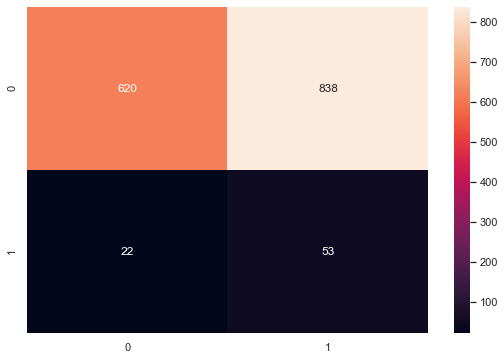

In [97]:
import seaborn as sns
labels = ["Stroke", "non stroke"]
cf_matrix = confusion_matrix(y_test, test_preds)

sns.heatmap(cf_matrix, fmt='g',annot=True)
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()

tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
print("tp - stroke predicted as stroke",tp)
print("tn - non stroke predicted as non stroke",tn)
print("fn - Stroke predicted as non stroke",fn)
print("fp - non stroke predicted as stroke",fp)
print('Sensitivity',tp / float(tp+fn))
print('specificity',tn / float(fp+tn))

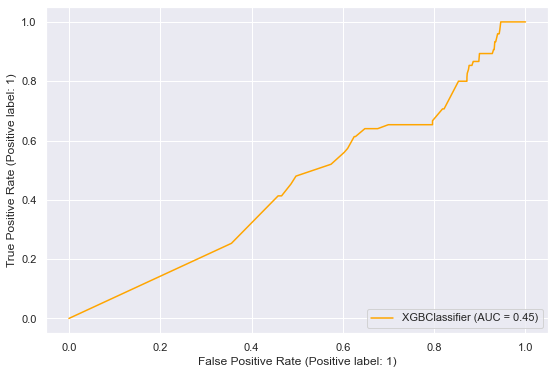

In [98]:
metrics.plot_roc_curve(xgb, X_test, y_test)

Inference: Out of all the algorithms XGBoost and Neural networks are giving good recall rate. Hence these two can be finalised.